In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("=== VALIDAÇÃO CRUZADA HOLDOUT (75/25) ===\n")

# 1. CARREGAR OS DADOS
def load_boston_data():
    """Carrega dataset similar ao Boston Housing"""
    try:
        # Usar California Housing como alternativa
        california = fetch_california_housing()
        dt = pd.DataFrame(california.data, columns=california.feature_names)
        dt['medv'] = california.target * 100000  # Converter para escala similar
        print("Dataset California Housing carregado")
        return dt
    except:
        # Dataset de exemplo se não conseguir carregar
        print("Criando dataset de exemplo...")
        np.random.seed(42)
        n_samples = 506  # Mesmo tamanho do Boston
        dt = pd.DataFrame({
            'crim': np.random.exponential(1, n_samples),
            'zn': np.random.randint(0, 100, n_samples),
            'indus': np.random.uniform(2, 30, n_samples),
            'chas': np.random.choice([0, 1], n_samples),
            'nox': np.random.uniform(0.3, 0.9, n_samples),
            'rm': np.random.uniform(3, 9, n_samples),
            'age': np.random.uniform(20, 100, n_samples),
            'dis': np.random.exponential(3, n_samples),
            'rad': np.random.randint(1, 25, n_samples),
            'tax': np.random.randint(200, 700, n_samples),
            'ptratio': np.random.uniform(12, 23, n_samples),
            'black': np.random.uniform(300, 400, n_samples),
            'lstat': np.random.uniform(1, 40, n_samples),
            'medv': np.random.normal(20000, 10000, n_samples)
        })
        return dt

dt = load_boston_data()
print(f"Shape do dataset: {dt.shape}")

=== VALIDAÇÃO CRUZADA HOLDOUT (75/25) ===

Dataset California Housing carregado
Shape do dataset: (20640, 9)


In [3]:
# 2. DIVISÃO TREINO/VALIDAÇÃO (75/25)
smp_size = int(0.75 * len(dt))
train_ind = np.random.choice(len(dt), size=smp_size, replace=False)

dtTrain = dt.iloc[train_ind]
dtVal = dt.drop(train_ind)

print(f"Treino: {len(dtTrain)} amostras")
print(f"Validação: {len(dtVal)} amostras")

Treino: 15480 amostras
Validação: 5160 amostras


In [5]:
# 3. MODELOS DE MACHINE LEARNING

# (1) REGRESSÃO LINEAR COM TERMO QUADRÁTICO
print("\n1. TREINANDO REGRESSÃO LINEAR...")
X_train = dtTrain.drop('medv', axis=1)
y_train = dtTrain['medv']
X_val = dtVal.drop('medv', axis=1)
y_val = dtVal['medv']

# Adicionar termo quadrático para lstat (como no R)
# X_train['lstat_squared'] = X_train['lstat'] ** 2
# X_val['lstat_squared'] = X_val['lstat'] ** 2

modelo_lm = LinearRegression()
modelo_lm.fit(X_train, y_train)
yhat_lm = modelo_lm.predict(X_val)


1. TREINANDO REGRESSÃO LINEAR...


In [6]:
# (2) ÁRVORE DE REGRESSÃO
print("2. TREINANDO ÁRVORE DE REGRESSÃO...")
modelo_cart = DecisionTreeRegressor(random_state=42)
modelo_cart.fit(X_train, y_train)
yhat_cart = modelo_cart.predict(X_val)

2. TREINANDO ÁRVORE DE REGRESSÃO...


In [7]:
# (3) RANDOM FOREST
print("3. TREINANDO RANDOM FOREST...")
modelo_RF = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_RF.fit(X_train, y_train)
yhat_RF = modelo_RF.predict(X_val)

3. TREINANDO RANDOM FOREST...


In [8]:
# 4. REDE NEURAL COM KERAS
print("4. TREINANDO REDE NEURAL...")

# Normalização usando dados de treino
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train_scaled = (y_train - y_train_mean) / y_train_std

# Modelo Keras
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae', 'mse']
)

# Treinamento simples (sem callbacks)
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=506,
    verbose=0
)

yhat_RNA_scaled = model.predict(X_val_scaled).flatten()
yhat_RNA = yhat_RNA_scaled * y_train_std + y_train_mean

4. TREINANDO REDE NEURAL...
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [9]:
# 5. REDE NEURAL COM EARLY STOPPING E LEARNING RATE ADAPTATIVO
print("5. TREINANDO RNA COM CALLBACKS...")

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min'
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    mode='min'
)

# Novo modelo
model2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model2.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae', 'mse']
)

# Treinamento com validação
history2 = model2.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, (y_val - y_train_mean) / y_train_std),
    epochs=500,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

yhat_RNA2_scaled = model2.predict(X_val_scaled).flatten()
yhat_RNA2 = yhat_RNA2_scaled * y_train_std + y_train_mean

5. TREINANDO RNA COM CALLBACKS...
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [10]:
# 6. MODELO BAYESIANO SIMPLIFICADO (alternativo ao Stan)
print("6. MODELO BAYESIANO SIMPLIFICADO...")

from sklearn.linear_model import BayesianRidge

modelo_bayes = BayesianRidge()
modelo_bayes.fit(X_train_scaled, y_train)
yhat_MLP = modelo_bayes.predict(X_val_scaled)

6. MODELO BAYESIANO SIMPLIFICADO...


In [11]:
# 7. CÁLCULO DAS MÉTRICAS
print("\n=== RESULTADOS ===\n")

y_true = y_val
n = len(y_true)

def calcular_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

s_lm = calcular_rmse(y_true, yhat_lm)
s_cart = calcular_rmse(y_true, yhat_cart)
s_RF = calcular_rmse(y_true, yhat_RF)
s_RNA = calcular_rmse(y_true, yhat_RNA)
s_RNA2 = calcular_rmse(y_true, yhat_RNA2)
s_MLP = calcular_rmse(y_true, yhat_MLP)

resultados = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Árvore CART', 'Random Forest',
               'RNA Simples', 'RNA com Callbacks', 'Bayesiano'],
    'RMSE': [s_lm, s_cart, s_RF, s_RNA, s_RNA2, s_MLP]
})

print(resultados.round(4))


=== RESULTADOS ===

              Modelo        RMSE
0   Regressão Linear  73435.9956
1        Árvore CART  68917.4610
2      Random Forest  49953.9717
3        RNA Simples  52703.0584
4  RNA com Callbacks  51027.4184
5          Bayesiano  73436.8030


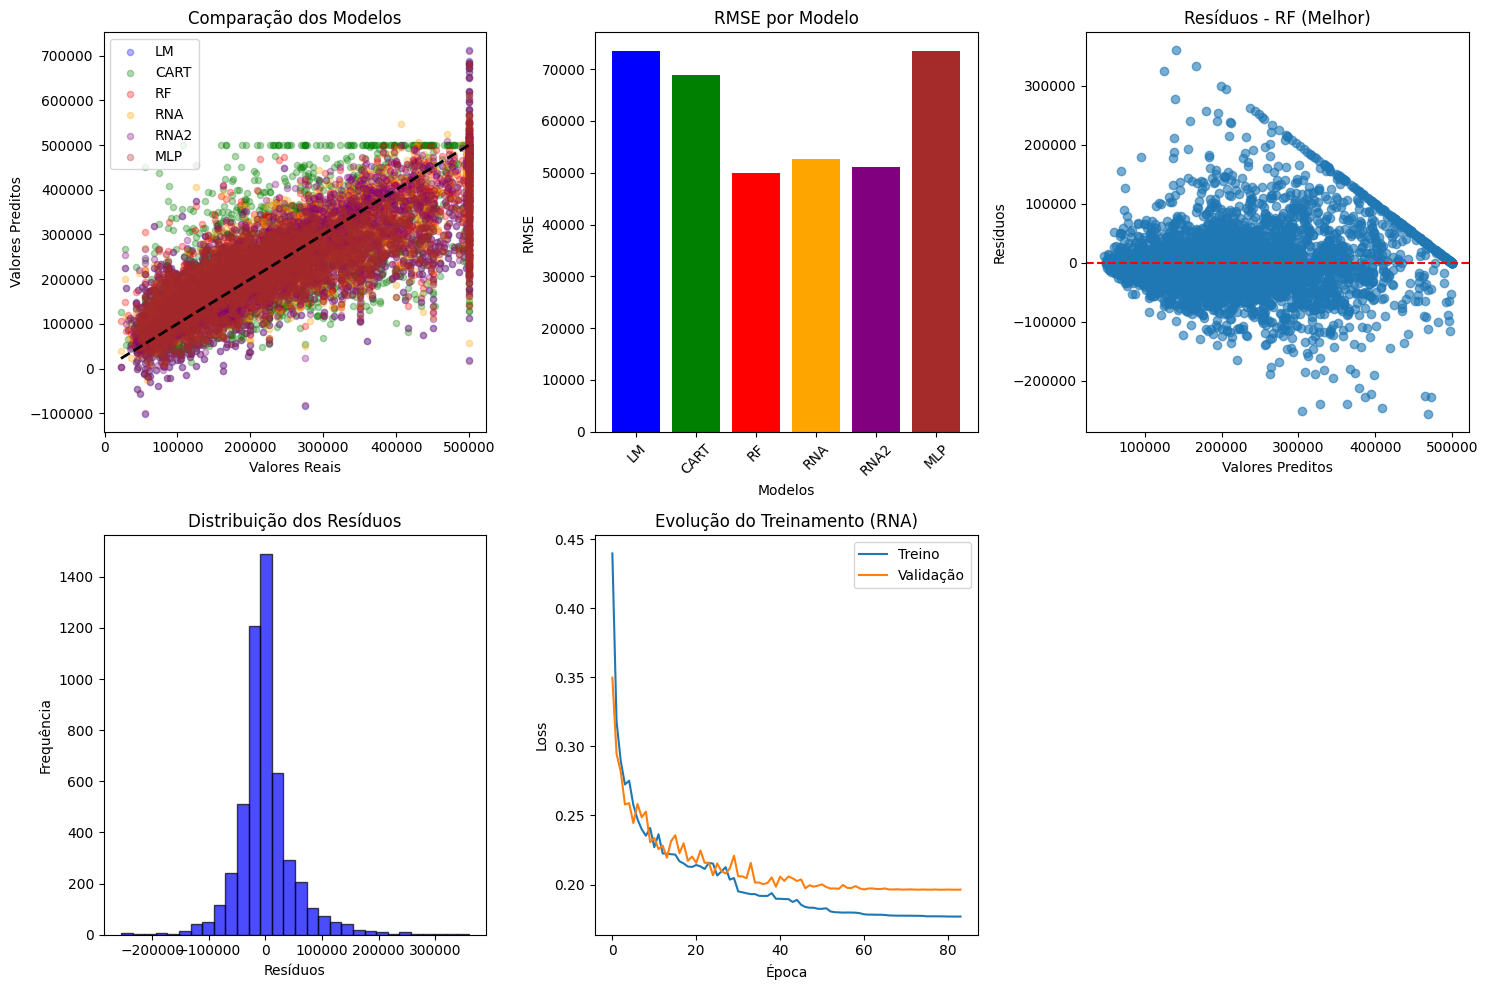

In [12]:
# 8. VISUALIZAÇÃO DOS RESULTADOS
plt.figure(figsize=(15, 10))

# Gráfico 1: Comparação de previsões
plt.subplot(2, 3, 1)
modelos = [yhat_lm, yhat_cart, yhat_RF, yhat_RNA, yhat_RNA2, yhat_MLP]
nomes = ['LM', 'CART', 'RF', 'RNA', 'RNA2', 'MLP']
cores = ['blue', 'green', 'red', 'orange', 'purple', 'brown']

for i, (y_pred, nome, cor) in enumerate(zip(modelos, nomes, cores)):
    plt.scatter(y_true, y_pred, alpha=0.3, label=nome, color=cor, s=20)

plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Comparação dos Modelos')
plt.legend()

# Gráfico 2: RMSE comparativo
plt.subplot(2, 3, 2)
plt.bar(nomes, [s_lm, s_cart, s_RF, s_RNA, s_RNA2, s_MLP], color=cores)
plt.xlabel('Modelos')
plt.ylabel('RMSE')
plt.title('RMSE por Modelo')
plt.xticks(rotation=45)

# Gráfico 3: Resíduos do melhor modelo
melhor_idx = np.argmin([s_lm, s_cart, s_RF, s_RNA, s_RNA2, s_MLP])
melhor_modelo = modelos[melhor_idx]
melhor_nome = nomes[melhor_idx]

plt.subplot(2, 3, 3)
residuos = y_true - melhor_modelo
plt.scatter(melhor_modelo, residuos, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title(f'Resíduos - {melhor_nome} (Melhor)')

# Gráfico 4: Histograma dos resíduos
plt.subplot(2, 3, 4)
plt.hist(residuos, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')

# Gráfico 5: Evolução do treinamento da RNA
plt.subplot(2, 3, 5)
plt.plot(history2.history['loss'], label='Treino')
plt.plot(history2.history['val_loss'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução do Treinamento (RNA)')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# 9. SALVAR RESULTADOS
resultados.to_excel('resultados_holdout.xlsx', index=False)
print(f"\nResultados salvos em 'resultados_holdout.xlsx'")

print("\n=== ANÁLISE CONCLUÍDA ===")


Resultados salvos em 'resultados_holdout.xlsx'

=== ANÁLISE CONCLUÍDA ===
